# Analysis of ROS inhibition in KT model

## Load libraries

In [77]:
import cobra
import pandas as pd
from sampling_utils import run_flux_sampling, run_ks_test, plot_pca_samples, plot_distributions

## Load model

In [2]:
ROS_model=cobra.io.read_sbml_model("ros_model.xml")

## Constrain the model

In [3]:

from cobra.flux_analysis import flux_variability_analysis

def constrain_model_by_ROS(
    model,
    carbon_source_rxn="EX_glc__D_e",
    ROS_rxn="DM_h2o2_c",
    rango=(0.02, 3.0),
    reactions_to_constrain=None,
    carbon_uptake=-6.3,
    fraction_of_optimum=0.9
):
    """
    Constrains a GEM based on ROS production using FBA and FVA.

    Parameters
    ----------
    model : cobra.Model
        Genome-scale metabolic model (GEM).

    carbon_source_rxn : str
        Reaction ID of the carbon source exchange (e.g. 'EX_glc__D_e').

    ROS_rxn : str, optional
        Reaction ID of the target product exchange reaction to be maximized
        during FBA (default is 'EX_ROS_e').

    rango : tuple(float, float)
        Expected flux range (min, max) for pepito production.
        Values below the minimum are mapped to 0.2, values above the maximum
        are mapped to 0.8, and intermediate values are linearly scaled.

    reactions_to_constrain : list of str
        List of reaction IDs whose flux bounds will be constrained
        based on normalized pepito production and FVA results.

    carbon_uptake : float, optional
        Lower bound for carbon source uptake (negative value for uptake,
        default is -10.0).

    Returns
    -------
    dict
        Dictionary containing:
        - 'model' : cobra.Model
            Constrained model.
        - 'ROS_flux' : float
            Optimal pepito flux obtained from FBA.
        - 'normalized_value' : float
            Normalized value between 0.2 and 0.8.
        - 'fva' : pandas.DataFrame
            Flux Variability Analysis results for the constrained reactions.
    """

    if reactions_to_constrain is None:
        raise ValueError("Suply reactions related with ROS")

    model_cons = model.copy()

    # 1. Define carbon source
    # Delete default source
    model_cons.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
    model_cons.reactions.get_by_id(carbon_source_rxn).lower_bound = carbon_uptake

    # 2. FBA maximizing ROS
    #model_cons.objective = ROS_rxn #EVALUAR SI OPTIMIZACION O NO
    sol = model_cons.optimize()

    ROS_flux = sol.fluxes[ROS_rxn]  # Get total flux of ROS

    # 3. Normalization
    rmin, rmax = rango

    if ROS_flux <= rmin:
        norm_value = 0.2
    elif ROS_flux >= rmax:
        norm_value = 0.8
    else:
        norm_value = 0.2 + (ROS_flux - rmin) * ((0.8-0.2) / (rmax - rmin))

    # 4. FVA
    fva_res = flux_variability_analysis(
        model_cons,
        reaction_list=reactions_to_constrain,
        fraction_of_optimum=fraction_of_optimum
    )

    for rxn_id in reactions_to_constrain:
        rxn = model_cons.reactions.get_by_id(rxn_id)

        fva_min = fva_res.loc[rxn_id, "minimum"]
        fva_max = fva_res.loc[rxn_id, "maximum"]

        rxn.lower_bound = fva_min * norm_value
        rxn.upper_bound = fva_max * norm_value

    return {
        "model": model_cons,
        "ROS_flux": ROS_flux,
        "normalized_value": norm_value,
        "fva": fva_res
    }


In [4]:
ROS_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002594,0,0.00%
cl_e,EX_cl_e,0.002594,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001866,0,0.00%
cu2_e,EX_cu2_e,0.001729,0,0.00%
fe2_e,EX_fe2_e,0.009015,0,0.00%
glc__D_e,EX_glc__D_e,6.3,0,0.00%
k_e,EX_k_e,0.0973,0,0.00%
mg2_e,EX_mg2_e,0.004324,0,0.00%
mn2_e,EX_mn2_e,0.001729,0,0.00%
mobd_e,EX_mobd_e,0.002003,0,0.00%


In [5]:
# Get list of susceptible reactions to constrain in the model
ROS_data = pd.read_csv('/home/ROS/Pputida_evidenced.txt', sep = '\t', encoding = 'latin1')
ROS_data.head()


,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0732,Q88PW6,hemA,Glutamyl-tRNA reductase,1,3.83,1,6,4.85,1,0,0.0,NaN,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,BRENDA,NaN,1.2.1.70,Oxidoreductases,suggesting that cysteine residues are the prim...,Acidithiobacillus ferrooxidans
1,PP_4715,Q88DV4,tpiA,Triosephosphate isomerase,1,4.37,0,1,5.10,0,0,0.0,NaN,S_Gluconeogenesis,BRENDA,NaN,5.3.1.1,Isomerases,oxidation of cystein residues,Arabidopsis thaliana AND Chlamydomonas reinhar...
2,PP_3668,Q88GQ0,katG,Catalase-peroxidase,1,3.86,0,2,5.24,0,0,0.0,heme b (C34H30FeN4O4),Unassigned,BRENDA,NaN,1.11.1.21,Oxidoreductases,"Steinman, H.M.; Fareed, F.; Weinstein, L.: Ca...",Archaeoglobus fulgidus AND Rhodobacter capsula...
3,PP_1001,Q88P52,arcA,Arginine deiminase,1,3.87,1,0,0.00,0,0,0.0,NaN,S_Arginine_and_Proline_Metabolism,BRENDA,NaN,3.5.3.6,Hydrolases,oxidation of cystein residues,Aspergillus nidulans
4,PP_0398,Q88QT9,glpE,Thiosulfate sulfurtransferase GlpE,1,3.85,1,0,0.00,0,0,0.0,NaN,S_Sulfur_Metabolism,BRENDA,NaN,2.8.1.1,Transferases,"In the absence of reduced thioredoxin, the sul...",Bos taurus


In [6]:
susceptible_enz = ROS_data["KEGG ID"].tolist()

In [7]:
# Get only those reactions having all its enzymes affected
import re


ROS_reactions_list = []
pattern = r'PP_\d{4}'

reactions_gpr = {}
for rxn in ROS_model.reactions:
    matches = re.findall(pattern, str(rxn.gpr))
    if matches:
        reactions_gpr[rxn.id] = matches

for reaction, gprs in reactions_gpr.items():
    if set(gprs).issubset(set(susceptible_enz)):
        ROS_reactions_list.append(reaction)
        print(f'\nReaction {reaction} is inhibited by ROS')
        print(ROS_model.reactions.get_by_id(reaction))


Reaction 34HPPOR is inhibited by ROS
34HPPOR: 34hpp_c + o2_c --> co2_c + hgentis_c

Reaction ACONTb is inhibited by ROS
ACONTb: acon_C_c + h2o_c <=> icit_c

Reaction ARGDr is inhibited by ROS
ARGDr: arg__L_c + h2o_c --> citr__L_c + nh4_c

Reaction CAT is inhibited by ROS
CAT: 2.0 h2o2_c --> 2.0 h2o_c + o2_c

Reaction CATDOX is inhibited by ROS
CATDOX: catechol_c + o2_c --> ccmuac_c + 2.0 h_c

Reaction EDD is inhibited by ROS
EDD: 6pgc_c --> 2ddg6p_c + h2o_c

Reaction FALDM is inhibited by ROS
FALDM: 2.0 fald_c + h2o_c <=> for_c + h_c + meoh_c

Reaction GADOX is inhibited by ROS
GADOX: ga_c + o2_c --> 2.0 h_c + omaketo_c

Reaction GLUTRR is inhibited by ROS
GLUTRR: glutrna_c + h_c + nadph_c --> glu1sa_c + nadp_c + trnaglu_c

Reaction GTHPi is inhibited by ROS
GTHPi: 2.0 gthrd_c + h2o2_c --> gthox_c + 2.0 h2o_c

Reaction ICDHyr is inhibited by ROS
ICDHyr: icit_c + nadp_c <=> akg_c + co2_c + nadph_c

Reaction ICL is inhibited by ROS
ICL: icit_c --> glx_c + succ_c

Reaction MALEI is inhib

In [8]:
results_ROS=constrain_model_by_ROS(
    ROS_model,
    rango=(0.02, 0.6),
    reactions_to_constrain=ROS_reactions_list,
    carbon_uptake=-10.0
)

In [9]:
from pprint import pprint
pprint(results_ROS)

{'ROS_flux': np.float64(0.41772073611172195),
 'fva':                 minimum      maximum
34HPPOR        0.000000     0.989055
ACONTb        -0.797912    21.367115
ARGDr          0.000000    11.832928
CAT            0.000000     7.709398
CATDOX         0.000000     0.000000
EDD            0.000000    15.200850
FALDM         -0.000218     0.704906
GADOX          0.000000     0.000000
GLUTRR         0.006273     1.073328
GTHPi          0.000000     4.947646
ICDHyr       -18.047210     9.376143
ICL            0.000000    32.947446
MALEI          0.000000     0.000218
ME2            0.000000    11.930389
METGL          0.000000     1.457149
MICITDr        0.000000     4.445481
PYRDOX         0.000000     0.000218
RPE           -2.088029    22.267590
SELNPS         0.000000     0.000000
TMDS           0.009542     0.010603
TPI           -6.153296    15.262336
BETALDHx       0.000000     0.000000
BETALDHy       0.000000     0.000000
ACONTa_ROS_F   0.000000   691.278480
ACONTa_ROS_R   0.0000

## FBA

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
def compare_fba(model_original, model_modified, objective_rxn="BIOMASS_KT2440_WT3"):
    """
    Compare FBA fluxes between original and modified models.
    """

    m1 = model_original.copy()
    m2 = model_modified.copy()

    m1.objective = objective_rxn
    m2.objective = objective_rxn

    sol1 = m1.optimize()
    sol2 = m2.optimize()

    df = pd.DataFrame({
        "flux_original": sol1.fluxes,
        "flux_modified": sol2.fluxes
    })

    df["delta_flux"] = df["flux_modified"] - df["flux_original"]
    df["abs_delta_flux"] = df["delta_flux"].abs()

    return df.sort_values("abs_delta_flux", ascending=False), sol1.objective_value, sol2.objective_value


def plot_fba_changes(fba_df, top_n=20):
    df = fba_df.head(top_n)

    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df["delta_flux"])
    plt.axhline(0)
    plt.ylabel("Flux change (modified - original)")
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} FBA flux changes")
    plt.tight_layout()
    plt.show()

In [39]:
from cobra.flux_analysis import flux_variability_analysis

def compare_fva(model_original, model_modified, reaction_list):
    """
    Compare FVA ranges between original and modified models.
    """

    fva_orig = flux_variability_analysis(
        model_original, reaction_list=reaction_list
    )

    fva_mod = flux_variability_analysis(
        model_modified, reaction_list=reaction_list
    )

    df = pd.DataFrame(index=reaction_list)

    df["min_original"] = fva_orig["minimum"]
    df["max_original"] = fva_orig["maximum"]
    df["range_original"] = df["max_original"] - df["min_original"]

    df["min_modified"] = fva_mod["minimum"]
    df["max_modified"] = fva_mod["maximum"]
    df["range_modified"] = df["max_modified"] - df["min_modified"]

    df["delta_range"] = df["range_modified"] - df["range_original"]
    df["abs_delta_range"] = df["delta_range"].abs()

    return df.sort_values("abs_delta_range", ascending=False)

In [40]:
def plot_fva_range_changes(fva_df, top_n=20):
    df = fva_df.head(top_n)

    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df["delta_range"])
    plt.axhline(0)
    plt.ylabel("Range change (modified - original)")
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} FVA range changes")
    plt.tight_layout()
    plt.show()


In [41]:
# Compare original model vs constrained model
cons_model = results_ROS["model"]
fba_comparison = compare_fba(ROS_model, cons_model)

In [42]:
df_comp = fba_comparison[0]
df_comp

,flux_original,flux_modified,delta_flux,abs_delta_flux
CYO1_KT_ROS,0.000000,39.139639,39.139639,39.139639
CYTCBB3pp,0.000000,39.139639,39.139639,39.139639
CYTBO3_4pp_ROS,23.760608,0.000000,-23.760608,23.760608
H2Otpp,-35.152389,-47.806120,-12.653731,12.653731
NADH16pp_ROS,14.513657,25.630431,11.116774,11.116774
...,...,...,...,...
NFORGLUAH2,0.000000,0.000000,0.000000,0.000000
NAt3_2pp,0.000000,0.000000,0.000000,0.000000
NAt3pp,0.000000,0.000000,0.000000,0.000000
NBAHH_ir,0.000000,0.000000,0.000000,0.000000


In [43]:
delta_flux_th = 0.1
modified = df_comp[df_comp["abs_delta_flux"] > delta_flux_th]
modified

,flux_original,flux_modified,delta_flux,abs_delta_flux
CYO1_KT_ROS,0.000000,39.139639,39.139639,39.139639
CYTCBB3pp,0.000000,39.139639,39.139639,39.139639
CYTBO3_4pp_ROS,23.760608,0.000000,-23.760608,23.760608
H2Otpp,-35.152389,-47.806120,-12.653731,12.653731
NADH16pp_ROS,14.513657,25.630431,11.116774,11.116774
...,...,...,...,...
GRXR,0.112008,0.000000,-0.112008,0.112008
GTHOr,0.112008,0.000000,-0.112008,0.112008
APSR2,0.112008,0.000000,-0.112008,0.112008
APSR,0.000000,0.108989,0.108989,0.108989


In [44]:
# Get objective value for each case
print('Original objective value:', fba_comparison[1])
print('Final objective value:', fba_comparison[2])

Original objective value: 0.6138367724869521
Final objective value: 0.5972943623579591


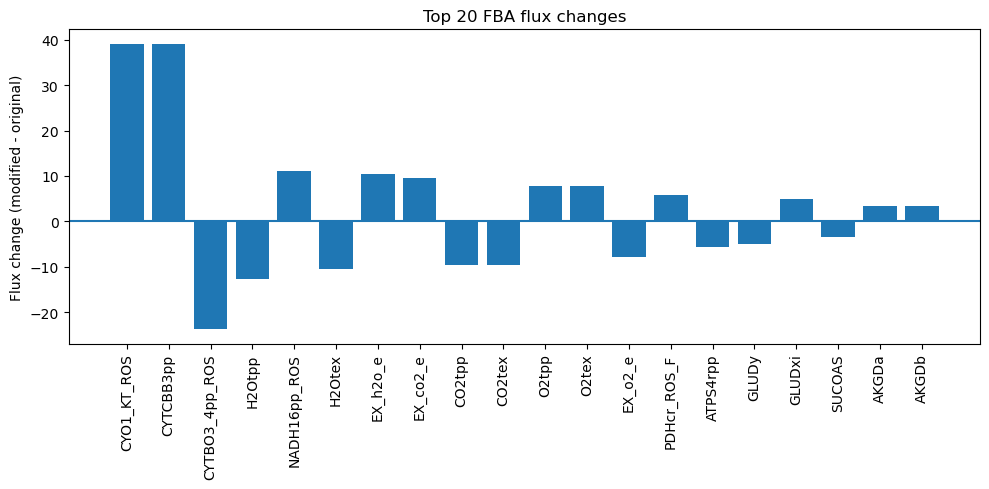

In [45]:
plot_fba_changes(df_comp)

## FVA

In [46]:
# Compare FVAs
fva_comp = compare_fva(ROS_model, cons_model, ROS_reactions_list)

In [47]:
fva_comp

,min_original,max_original,range_original,min_modified,max_modified,range_modified,delta_range,abs_delta_range
FUM_ROS_F,3.589825,3.589825e+00,-1.115552e-11,0.000000,611.435244,611.435244,6.114352e+02,6.114352e+02
PDHcr_ROS_F,8.698304,8.698304e+00,-6.059153e-12,0.000000,438.899006,438.899006,4.388990e+02,4.388990e+02
FUM_ROS_R,0.000000,-2.477062e-11,-2.477062e-11,0.000000,436.211731,436.211731,4.362117e+02,4.362117e+02
PDHcr_ROS_R,0.000000,2.839627e-11,2.839627e-11,0.000000,429.786554,429.786554,4.297866e+02,4.297866e+02
ACONTa_ROS_F,3.688494,3.688494e+00,-5.717649e-12,0.000000,422.672026,422.672026,4.226720e+02,4.226720e+02
ACONTa_ROS_R,0.000000,-5.295999e-12,-5.295999e-12,0.000000,419.189973,419.189973,4.191900e+02,4.191900e+02
ICL,0.000000,1.440095e+00,1.440095e+00,0.000000,20.145229,20.145229,1.870513e+01,1.870513e+01
ICDHyr,2.248399,3.688494e+00,1.440095e+00,-11.034700,5.732904,16.767604,1.532751e+01,1.532751e+01
RPE,0.080604,8.060413e-02,5.398071e-12,-1.276694,13.615189,14.891884,1.489188e+01,1.489188e+01
ACONTb,3.688494,3.688494e+00,5.278000e-12,-0.487871,13.064607,13.552478,1.355248e+01,1.355248e+01


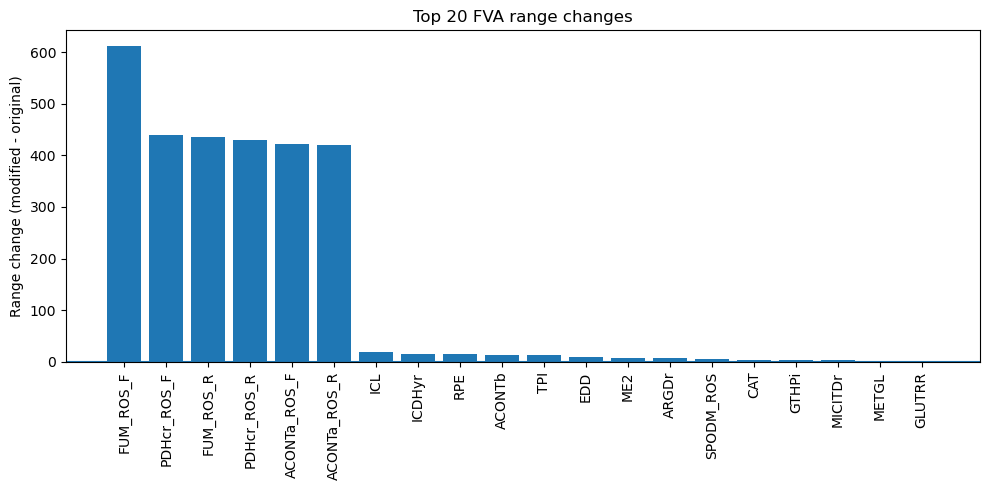

In [48]:
plot_fva_range_changes(fva_comp)

Un cambio positivo en el rango de FVA implica que una reacción ha dejado de ser tan limitante. Es decir, antes tenía un flujo más estricto, por lo que era una reacción importante para optimizar la función objetivo. Ahora el rango de flujos es mucho más laxo, permite más variabilidad entre todas las posibles soluciones, por lo que ha dejado de ser una reacción tan importante, compensando con otras rutas que permitan la adaptación del metabolismo a las constricciones aplicadas.

Casualmente, las reacciones que experimentan un cambio más evidente en FVA son productoras de ROS. Esto quiere decir que el metabolismo cambia los flujos y trata de evitar pasar por esas reacciones productoras de ROS. Seguramente existan rutas alternativas. 

In [2]:
# df_all, df_candidates = run_flux_sampling(ROS_model, cons_model, ROS_reactions_list)

In [75]:
df_all = pd.read_csv('sampling_results/all_reactions_flux_samples.csv', sep = ',')
df_candidates = pd.read_csv('sampling_results/candidate_reactions_flux_samples.csv', sep = ',')

Flux sampling chains showed good convergence, with Gelman–Rubin statistics (R̂) below 1.05 for all candidate reactions in both WT and ROS models.

¿Las soluciones metabólicas muestreadas del modelo WT y ROS son globalmente distintas? --> Modelo PCA

In [ ]:
# Plot PCA distributions of all samples
# plot_pca_samples(df_all)

Principal component analysis of flux sampling results revealed a partial but clear separation between WT and ROS models, indicating a global reorganization of the feasible metabolic solution space. While some overlap was observed, ROS samples explored a substantially broader region of the flux space, suggesting increased metabolic flexibility or alternative pathway usage under oxidative stress.

__Kolmogorov-Smirnov test__: compares 2 data distributions. 

$D$ measures the greatest absolute difference between the Cumulative Distribution Functions (CDF). If high, distributions are different.

$p_value$ indicates the probability that this difference occurrs if both samples came from the same distribution

Tries to measure if there is a difference between the flux distributions for a given reaction in wt and ros models

In [51]:
ks_results = run_ks_test(df_candidates)

In [58]:
# Adjust p-values
from statsmodels.stats.multitest import multipletests

ks_results["p_adj"] = multipletests(
    ks_results["pvalue"],
    method = "fdr_bh"
)[1]

ks_results

,reaction,pvalue,p_adj
0,34HPPOR,0.000000e+00,0.000000e+00
1,ACONTb,0.000000e+00,0.000000e+00
2,ARGDr,0.000000e+00,0.000000e+00
3,CAT,0.000000e+00,0.000000e+00
4,CATDOX,0.000000e+00,0.000000e+00
5,EDD,0.000000e+00,0.000000e+00
6,FALDM,0.000000e+00,0.000000e+00
7,GADOX,1.000000e+00,1.000000e+00
8,GLUTRR,0.000000e+00,0.000000e+00
9,GTHPi,0.000000e+00,0.000000e+00


Except for reaction "GADOX", all the others show a statistically different distribution in wt and ros data

In [1]:
# Plot distributions and store them as .png files
# plot_distributions(df_candidates)